# 天猫用户复购预测

## 项目背景

电商会在双11、黑五等时间进行大量促销活动来吸引买家，然而，很多被吸引的买家都是一次性交易，这些促销对于转换为长期的顾客来说可能收效甚微。为了便于商家识别哪些用户可以成为重复购买的忠实买家，从而降低促销成本，提高投资回报率（ROI），天猫提供了“双11”前6个月和“双11”当天匿名用户的购物日志信息以及是否为重复购买者的标签信息，**目标是对于给定的商家，预测新用户是否能成为忠诚用户，即未来6个月内会购买这个商家的商品。**

## 项目分析思维导图

<div>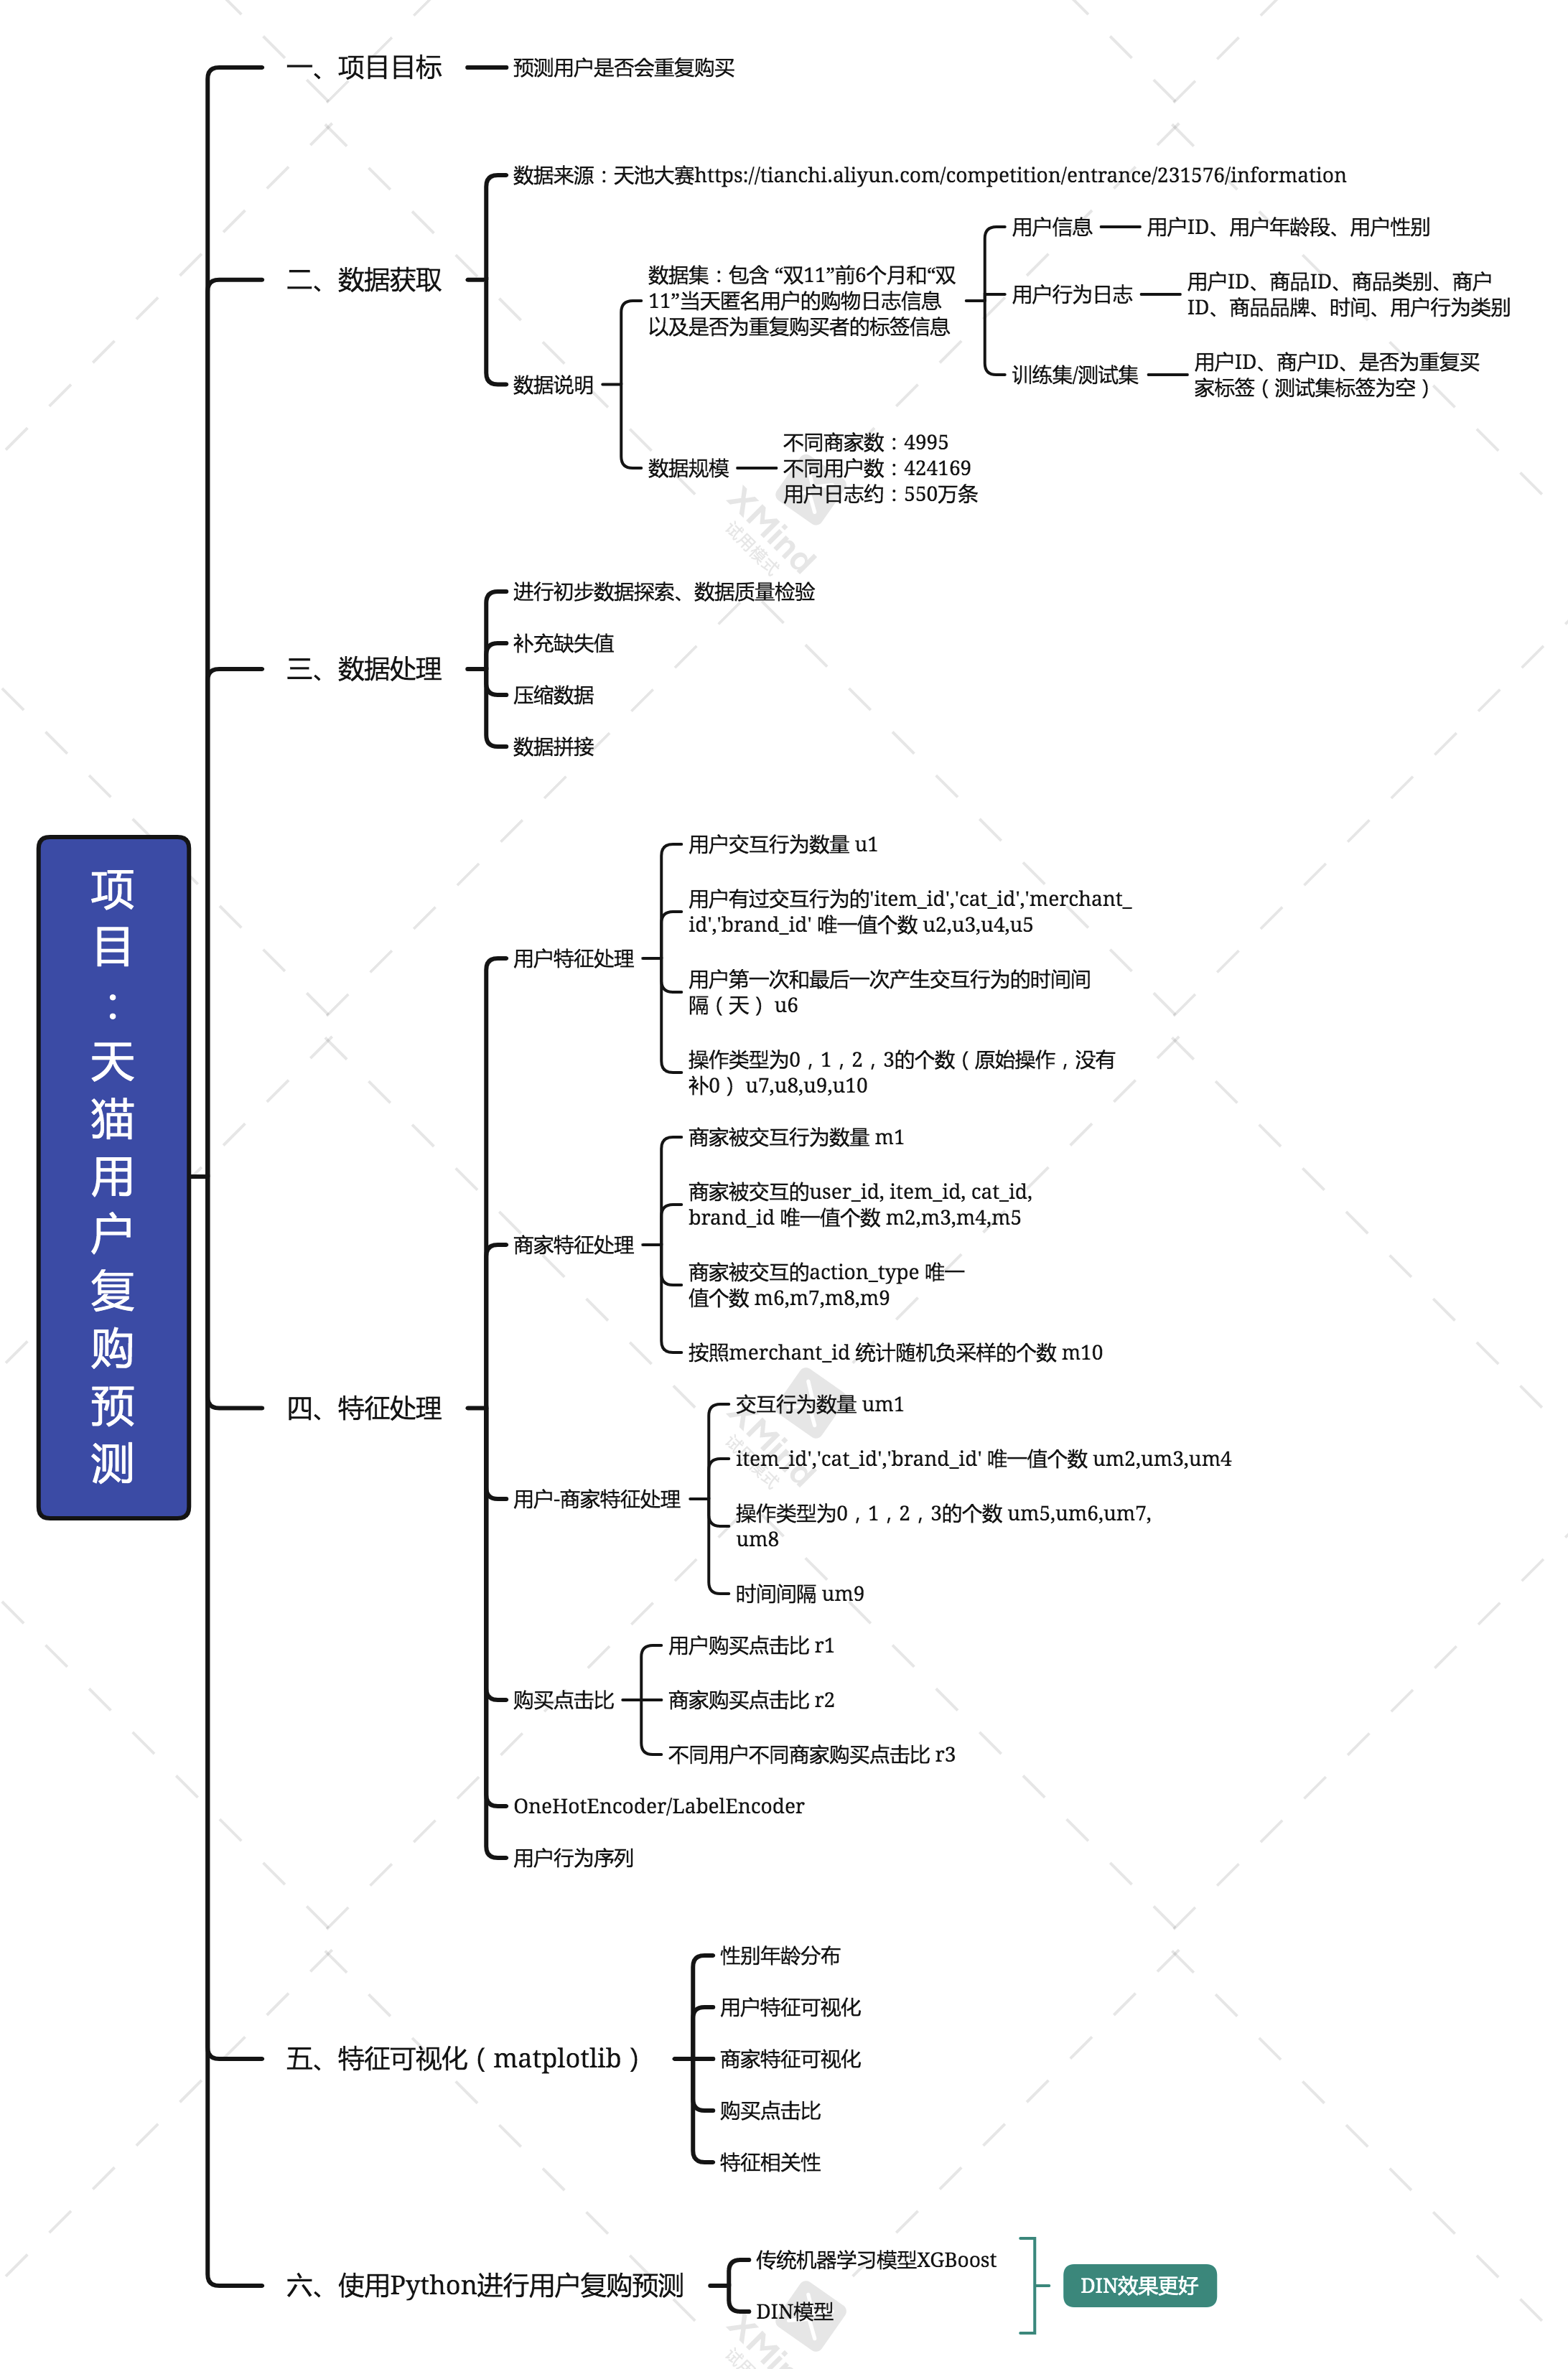</div>

## 数据处理

In [6]:
## 代码是在Google Colab中运行的
from google.colab import drive
drive.mount('/content/gdrive') #挂载网盘

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import os
os.chdir("/content/gdrive/My Drive/RS/Repeat Buyers Prediction") #改变当前工作目录到指定的路径

In [ ]:
!pip install tqdm
%tensorflow_version 1.x
!pip install -q deepctr[gpu]

In [141]:
#环境
import sys
print(sys.version)

import deepctr
print(deepctr.__version__)

import tensorflow as tf
print(tf.__version__)

if tf.test.gpu_device_name():
  print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
  print("Please install GPU version of TF")

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
0.9.0
1.15.2
Default GPU Device: /device:GPU:0


In [8]:
# 下载中文字体
!gdown --id 1fsKERl26TNTFIY25PhReoCujxwJvfyHn
import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='SimHei .ttf')

Downloading...
From: https://drive.google.com/uc?id=1fsKERl26TNTFIY25PhReoCujxwJvfyHn
To: /content/gdrive/My Drive/RS/Repeat Buyers Prediction/SimHei .ttf
100% 10.1M/10.1M [00:00<00:00, 38.1MB/s]


In [9]:
# !/usr/bin/env python
# -*- coding=utf-8 -*-

# 数据处理相关库
import pandas as pd 
import numpy as np
import gc

# 画图
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False # 解决负号问题
plt.rcParams['font.sans-serif']='SimHei'# 设置中文显示
plt.rcParams['font.size']=14 # 设置字体大小
import seaborn as sns

#忽略警号
import warnings
warnings.filterwarnings("ignore")

**数据集**包含“双11”前6个月和“双11”当天匿名用户的购物日志，以及显示他们是否为重复购买者的标签信息。
* label: 1'表示'user_id'是'merchant_id'的重复买家，'0'则表示不是，'-1'表示'user_id'不是给定商家的新客户
* activity_log: {userid, merchantid}之间的每组交易中都记录有itemid, categoryid, brand_id, time，用#分隔。记录不按任何特定顺序排序

In [136]:
# 使用format1进行加载
# 加载全量样本
user_log = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1/user_log_format1.csv', dtype={'time_stamp':'str'})
user_info = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1/user_info_format1.csv')
train_data1 = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1/train_format1.csv')
submission = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1/test_format1.csv')

# # 加载小样本
# user_log = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1_small/sample_user_log.csv', dtype={'time_stamp':'str'})
# user_info = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1_small/sample_user_info.csv')
# train_data1 = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1_small/train.csv')
# submission = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1_small/test.csv')

print('ok')

ok


**user_info**
* age_range，用户年龄范围。小于18岁为1；[18,24]为2；[25,29]为3；[30,34]为4；[35,39]为5；[40,49]为6；大于等于50时为7和8;0和NULL表示未知
* gender，用户性别。0表示女性，1表示男性，2和NULL表示未知

In [12]:
print(user_info.head(3).append(user_info.tail(3)))
#print(user_info.describe())
print(user_info.info())

        user_id  age_range  gender
0        376517        6.0     1.0
1        234512        5.0     0.0
2        344532        5.0     0.0
424167   208016        NaN     NaN
424168   272535        6.0     1.0
424169    18031        3.0     1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB
None


In [13]:
user_info['age_range'].fillna(0,inplace=True)# 0和NULL表示未知
user_info['age_range'] = user_info['age_range'].astype('int8')
user_info['gender'].fillna(2,inplace=True)# 2和NULL表示未知
user_info['gender'] = user_info['gender'].astype('int8')
print(user_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    424170 non-null  int64
 1   age_range  424170 non-null  int8 
 2   gender     424170 non-null  int8 
dtypes: int64(1), int8(2)
memory usage: 4.0 MB
None


Text(0.5, 1.0, '用户年龄分布')

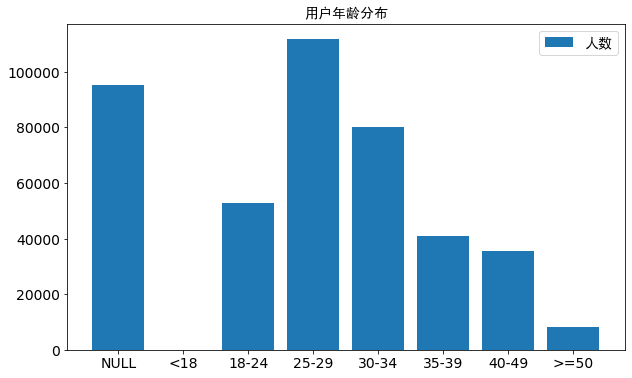

In [38]:
fig = plt.figure(figsize = (10, 6))
x = np.array(["NULL","<18","18-24","25-29","30-34","35-39","40-49",">=50"])
#<18岁为1；[18,24]为2； [25,29]为3； [30,34]为4；[35,39]为5；[40,49]为6； > = 50时为7和8
y = np.array([user_info[user_info['age_range'] == 0]['age_range'].count(),
             user_info[user_info['age_range'] == 1]['age_range'].count(),
             user_info[user_info['age_range'] == 2]['age_range'].count(),
             user_info[user_info['age_range'] == 3]['age_range'].count(),
             user_info[user_info['age_range'] == 4]['age_range'].count(),
             user_info[user_info['age_range'] == 5]['age_range'].count(),
             user_info[user_info['age_range'] == 6]['age_range'].count(),
             user_info[user_info['age_range'] == 7]['age_range'].count() + user_info[user_info['age_range'] == 8]['age_range'].count()])
plt.bar(x,y,label='人数')
plt.legend(prop=zhfont) ###
plt.title('用户年龄分布',fontproperties=zhfont) ###

Text(0.5, 1.0, '用户性别分布')

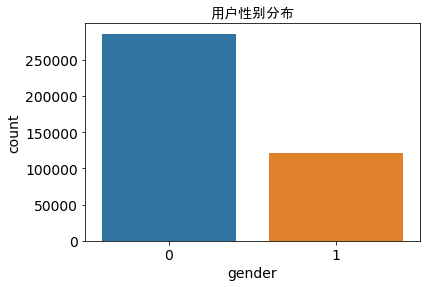

In [40]:
sns.countplot(x='gender',order = [0,1],data = user_info)
plt.title('用户性别分布',fontproperties=zhfont) ###

Text(0.5, 1.0, '用户性别年龄分布')

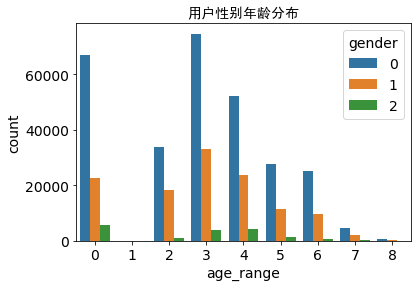

In [42]:
sns.countplot(x = 'age_range', order = [0,1,2,3,4,5,6,7,8],hue= 'gender',data = user_info)
plt.title('用户性别年龄分布',fontproperties=zhfont) ###

**user_log**
* action_type，包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹

In [ ]:
# 使用merchant_id（原列名seller_id）
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)
# 格式化,压缩数据
user_log['user_id'] = user_log['user_id'].astype('int32')
user_log['merchant_id'] = user_log['merchant_id'].astype('int32')
user_log['item_id'] = user_log['item_id'].astype('int32')
user_log['cat_id'] = user_log['cat_id'].astype('int32')
user_log['brand_id'].fillna(0, inplace=True)
user_log['brand_id'] = user_log['brand_id'].astype('int32')
# 添加一个临时年2020年
user_log['time_stamp'] = user_log['time_stamp'].astype('str').apply(lambda x:'2020'+x)
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'],format='%Y%m%d')
user_log['action_type'] = user_log['action_type'].astype('int8')

print(user_log.head(3).append(user_log.tail(3)))
#print(user_log.describe())
print(user_log.info())

          user_id  item_id  cat_id  ...  brand_id  time_stamp action_type
0          328862   323294     833  ...      2661  2020-08-29           0
1          328862   844400    1271  ...      2661  2020-08-29           0
2          328862   575153    1271  ...      2661  2020-08-29           0
54925327   208016   449814     898  ...      7995  2020-11-10           0
54925328   208016   634856     898  ...      7995  2020-11-10           0
54925329   208016   272094     898  ...      7995  2020-11-11           0

[6 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int32         
 1   item_id      int32         
 2   cat_id       int32         
 3   merchant_id  int32         
 4   brand_id     int32         
 5   time_stamp   datetime64[ns]
 6   action_type  int8          
dtypes: datetime64[ns](1), int32(5), int8(1)
memo

**数据拼接**

In [ ]:
train_data1['origin'] = 'train'
submission['origin'] = 'test'

# 连接train、test表
matrix = pd.concat([train_data1, submission], ignore_index=True, sort=False)
# 连接user_info表
matrix = pd.merge(matrix,user_info,on='user_id',how='left')
matrix.drop(['prob'],axis=1,inplace=True)

#压缩数据
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['age_range'].fillna(0,inplace=True)# 0和NULL表示未知
matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'].fillna(2,inplace=True)# 2和NULL表示未知
matrix['gender'] = matrix['gender'].astype('int8')
matrix['merchant_id'] = matrix['merchant_id'].astype('int32')
matrix['label'] = matrix['label'].astype('str')

print(matrix.head(3))
#print(matrix.describe())
print(matrix.info())

   user_id  merchant_id label origin  age_range  gender
0    34176         3906   0.0  train          6       0
1    34176          121   0.0  train          6       0
2    34176         4356   1.0  train          6       0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      522341 non-null  int32 
 1   merchant_id  522341 non-null  int32 
 2   label        522341 non-null  object
 3   origin       522341 non-null  object
 4   age_range    522341 non-null  int8  
 5   gender       522341 non-null  int8  
dtypes: int32(2), int8(2), object(2)
memory usage: 16.9+ MB
None


## 特征处理

**用户特征处理**

In [ ]:
groups = user_log.groupby(['user_id'])

# 统计用户交互行为数量 u1
temp = groups.size().reset_index().rename(columns={0:'u1'})
matrix = pd.merge(matrix,temp,on='user_id',how='left')

In [ ]:
# 统计用户有过交互行为的'item_id','cat_id','merchant_id','brand_id' 不重复值个数 u2,u3,u4,u5
temp = groups['item_id','cat_id','merchant_id','brand_id'].nunique().reset_index().rename(columns={
    'item_id':'u2','cat_id':'u3','merchant_id':'u4','brand_id':'u5'})
matrix = pd.merge(matrix,temp,on='user_id',how='left')

In [ ]:
# 按天统计用户第一次和最后一次产生交互行为的时间间隔 u6
temp = groups['time_stamp'].agg([('F_time','min'),('L_time','max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.days
matrix = pd.merge(matrix,temp[['user_id', 'u6']],on='user_id',how='left')

In [ ]:
# 统计操作类型为0，1，2，3的个数（原始操作，没有补0） u7,u8,u9,u10
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'u7', 1:'u8', 2:'u9', 3:'u10'})
matrix = pd.merge(matrix,temp[['user_id', 'u7','u8','u9','u10']],on='user_id',how='left')

**商家特征处理**

In [ ]:
groups = user_log.groupby(['merchant_id'])

# 统计商家被交互行为数量 m1
temp = groups.size().reset_index().rename(columns={0:'m1'})
matrix = pd.merge(matrix,temp,on='merchant_id',how='left')

In [ ]:
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值个数 m2,m3,m4,m5
temp = groups['user_id', 'item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'user_id':'m2', 'item_id':'m3', 'cat_id':'m4', 'brand_id':'m5'})
matrix = pd.merge(matrix,temp,on='merchant_id',how='left')

In [ ]:
# 统计商家被交互的action_type 唯一值个数 m6,m7,m8,m9
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'m6', 1:'m7', 2:'m8', 3:'m9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [ ]:
# 按照merchant_id 统计随机负采样的个数
temp = train_data1[train_data1['label']==0].groupby(['merchant_id']).size().reset_index().rename(columns={0:'m10'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

**用户-商家特征处理**

In [ ]:
groups = user_log.groupby(['user_id','merchant_id'])

In [ ]:
#############
del user_info,user_log,train_data1,submission
gc.collect()

2641

In [ ]:
# 统计交互行为数量 um1
temp = groups.size().reset_index().rename(columns={0:'um1'})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')

In [ ]:
# 统计'item_id','cat_id','brand_id' 唯一值个数 um2,um3,um4
temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'um2', 'cat_id':'um3', 'brand_id':'um4'})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')

In [ ]:
# 统计操作类型为0，1，2，3的个数 um5,um6,um7,um8
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'um5', 1:'um6', 2:'um7', 3:'um8'})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')

In [ ]:
# 统计时间间隔 um9
temp = groups['time_stamp'].agg([('F_time','min'),('L_time','max')]).reset_index()
temp['um9'] = (temp['L_time'] - temp['F_time']).dt.days
matrix = matrix.merge(temp[['user_id','merchant_id','um9']], on=['user_id', 'merchant_id'], how='left')

**购买点击比**

In [ ]:
# 用户购买点击比 r1
matrix['r1'] = matrix['u9']/matrix['u7'] 

In [ ]:
# 商家购买点击比 r2
matrix['r2'] = matrix['m8']/matrix['m6'] 

In [ ]:
#不同用户不同商家购买点击比 r3
matrix['r3'] = matrix['um7']/matrix['um5']

In [ ]:
matrix

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,um1,um2,um3,um4,um5,um6,um7,um8,um9,r1,r2,r3
0,34176,3906,0.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0,16269,5819,308,20,2,14870.0,28.0,410.0,961.0,68.0,39,20,6,1,36.0,NaN,1.0,2.0,22,0.082927,0.027572,0.027778
1,34176,121,0.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0,79865,10931,1179,26,2,72265.0,121.0,4780.0,2699.0,817.0,14,1,1,1,13.0,NaN,1.0,NaN,3,0.082927,0.066145,0.076923
2,34176,4356,1.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0,7269,2281,67,15,2,6094.0,16.0,963.0,196.0,36.0,18,2,1,1,12.0,NaN,6.0,NaN,1,0.082927,0.158024,0.500000
3,34176,2217,0.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0,60202,16870,377,5,2,52230.0,101.0,3721.0,4150.0,1100.0,2,1,1,1,1.0,NaN,1.0,NaN,0,0.082927,0.071243,1.000000
4,230784,4818,0.0,train,0,0,54,31,17,20,19,163,47.0,NaN,7.0,NaN,48089,7500,461,27,2,43268.0,129.0,2733.0,1959.0,525.0,8,1,1,1,7.0,NaN,1.0,NaN,3,0.148936,0.063164,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522336,228479,3111,nan,test,6,0,2004,1173,71,278,282,184,1770.0,NaN,26.0,208.0,10105,4154,542,50,18,8997.0,9.0,687.0,412.0,66.0,5,2,1,1,4.0,NaN,1.0,NaN,1,0.014689,0.076359,0.250000
522337,97919,2341,nan,test,8,1,55,29,14,17,17,138,46.0,NaN,8.0,1.0,5543,1592,352,93,19,4548.0,6.0,815.0,174.0,84.0,2,1,1,1,1.0,NaN,1.0,NaN,0,0.173913,0.179200,1.000000
522338,97919,3971,nan,test,8,1,55,29,14,17,17,138,46.0,NaN,8.0,1.0,28892,7587,272,7,2,24602.0,94.0,2608.0,1588.0,703.0,16,5,2,1,12.0,NaN,4.0,NaN,9,0.173913,0.106008,0.333333
522339,32639,3536,nan,test,0,0,72,46,24,33,35,172,62.0,1.0,8.0,1.0,14027,4956,322,19,3,12807.0,29.0,793.0,398.0,304.0,3,2,1,1,2.0,NaN,1.0,NaN,0,0.129032,0.061919,0.500000


In [ ]:
#保存特征数据
matrix.to_csv('./um_features.csv', index=False)
print("ok")

ok


## 特征可视化

In [10]:
matrix = pd.read_csv('./um_features.csv')
matrix.head()

,user_id,merchant_id,label,origin,age_range,gender,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,um1,um2,um3,um4,um5,um6,um7,um8,um9,r1,r2,r3
0,34176,3906,0.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0,16269,5819,308,20,2,14870.0,28.0,410.0,961.0,68.0,39,20,6,1,36.0,NaN,1.0,2.0,22,0.082927,0.027572,0.027778
1,34176,121,0.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0,79865,10931,1179,26,2,72265.0,121.0,4780.0,2699.0,817.0,14,1,1,1,13.0,NaN,1.0,NaN,3,0.082927,0.066145,0.076923
2,34176,4356,1.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0,7269,2281,67,15,2,6094.0,16.0,963.0,196.0,36.0,18,2,1,1,12.0,NaN,6.0,NaN,1,0.082927,0.158024,0.500000
3,34176,2217,0.0,train,6,0,451,256,45,109,108,174,410.0,NaN,34.0,7.0,60202,16870,377,5,2,52230.0,101.0,3721.0,4150.0,1100.0,2,1,1,1,1.0,NaN,1.0,NaN,0,0.082927,0.071243,1.000000
4,230784,4818,0.0,train,0,0,54,31,17,20,19,163,47.0,NaN,7.0,NaN,48089,7500,461,27,2,43268.0,129.0,2733.0,1959.0,525.0,8,1,1,1,7.0,NaN,1.0,NaN,3,0.148936,0.063164,0.142857


In [71]:
train_data=matrix[matrix['origin'] == 'train'] #训练数据

Text(0.5, 1.0, '训练集用户性别年龄分布')

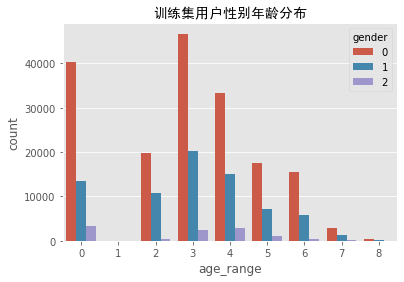

In [72]:
plt.style.use('ggplot')
sns.countplot(x = 'age_range', order = [0,1,2,3,4,5,6,7,8],hue= 'gender',data = train_data)
plt.title('训练集用户性别年龄分布',fontproperties=zhfont)

['user_id', 'merchant_id', 'label', 'origin', 'age_range', 'gender', 'u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8', 'u9', 'u10', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'um1', 'um2', 'um3', 'um4', 'um5', 'um6', 'um7', 'um8', 'um9', 'r1', 'r2', 'r3']


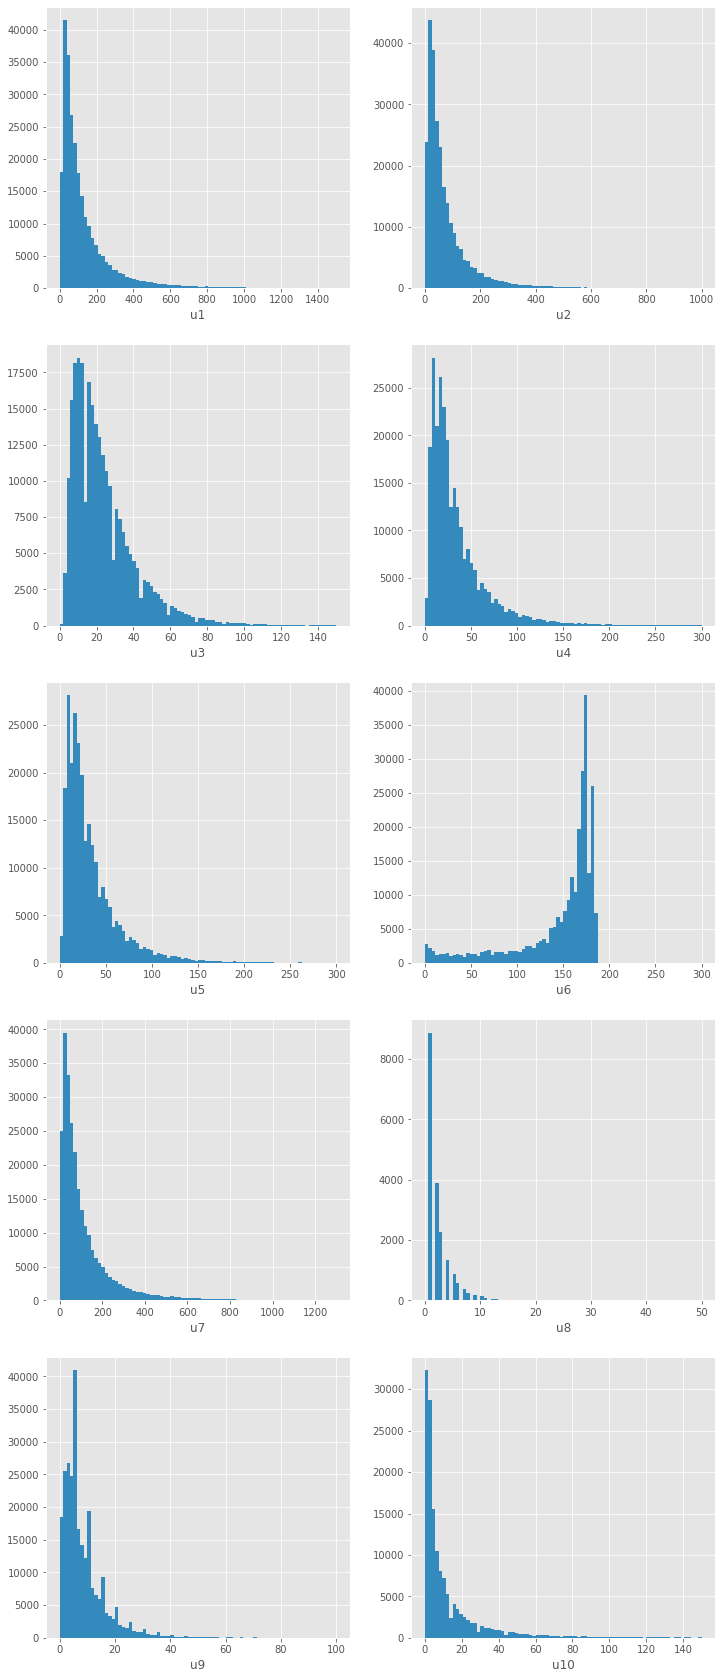

In [126]:
# 训练集用户特征分布
colnm = train_data.columns.tolist()
print(colnm)
color = sns.color_palette()
ranges=[1500,1000,150,300,300,300,1300,50,100,150]

fig = plt.figure(figsize=(12, 30))
for i in range(1, 11):
    plt.subplot(5, 2, i)
    plt.hist(train_data[colnm[i+5]],range=[0,ranges[i-1]],bins = 80,color = color[1])
    plt.xlabel(colnm[i+5],fontsize = 12)

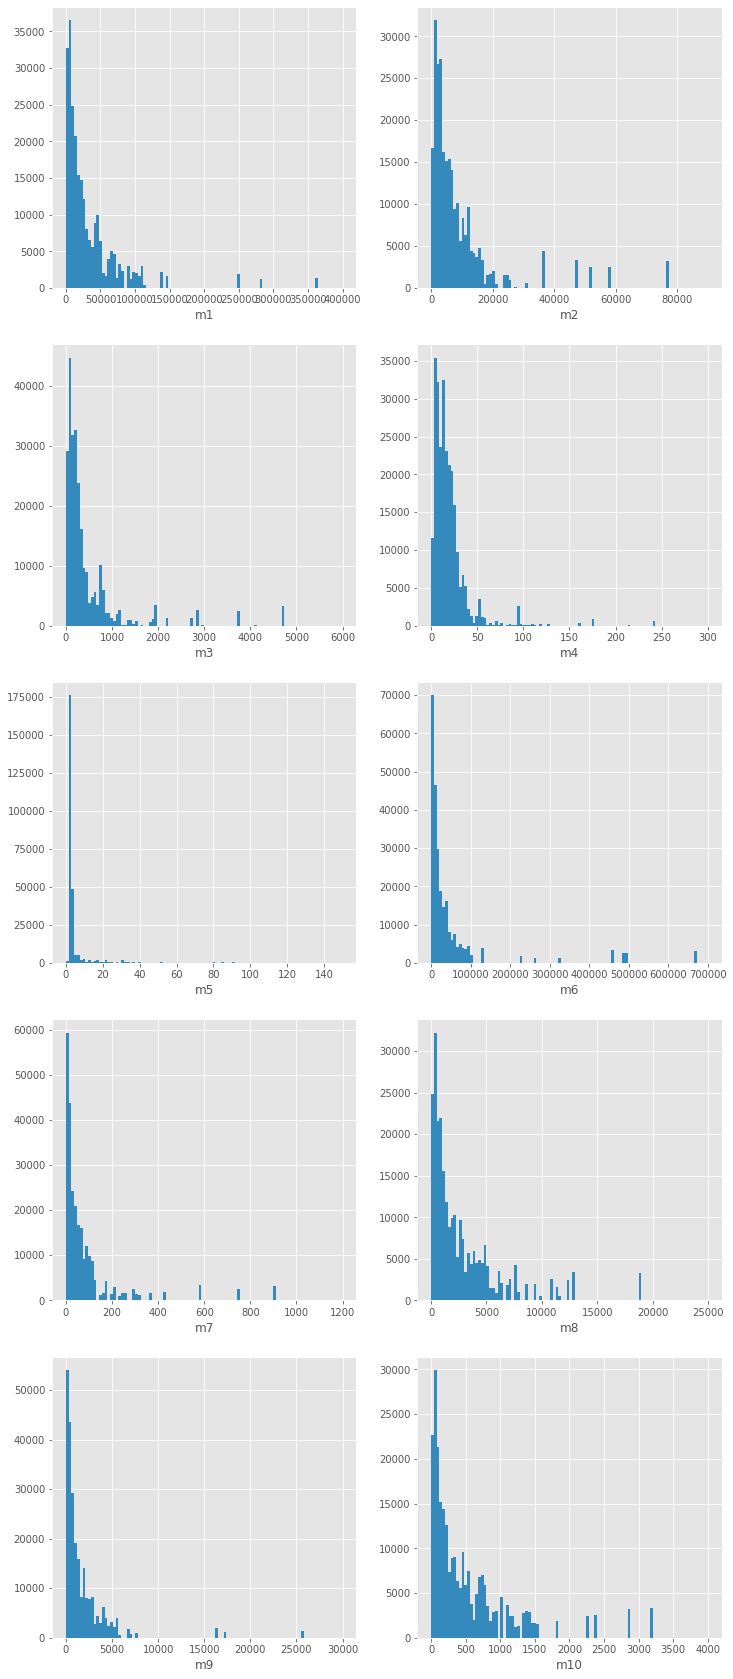

In [127]:
# 训练集商家特征分布
color = sns.color_palette()
ranges=[400000,90000,6000,300,150,700000,1200,25000,30000,4000]

fig = plt.figure(figsize=(12, 30))
for i in range(1, 11):
    plt.subplot(5, 2, i)
    plt.hist(train_data[colnm[i+15]],range=[0,ranges[i-1]],bins = 100,color = color[1])
    plt.xlabel(colnm[i+15],fontsize = 12)

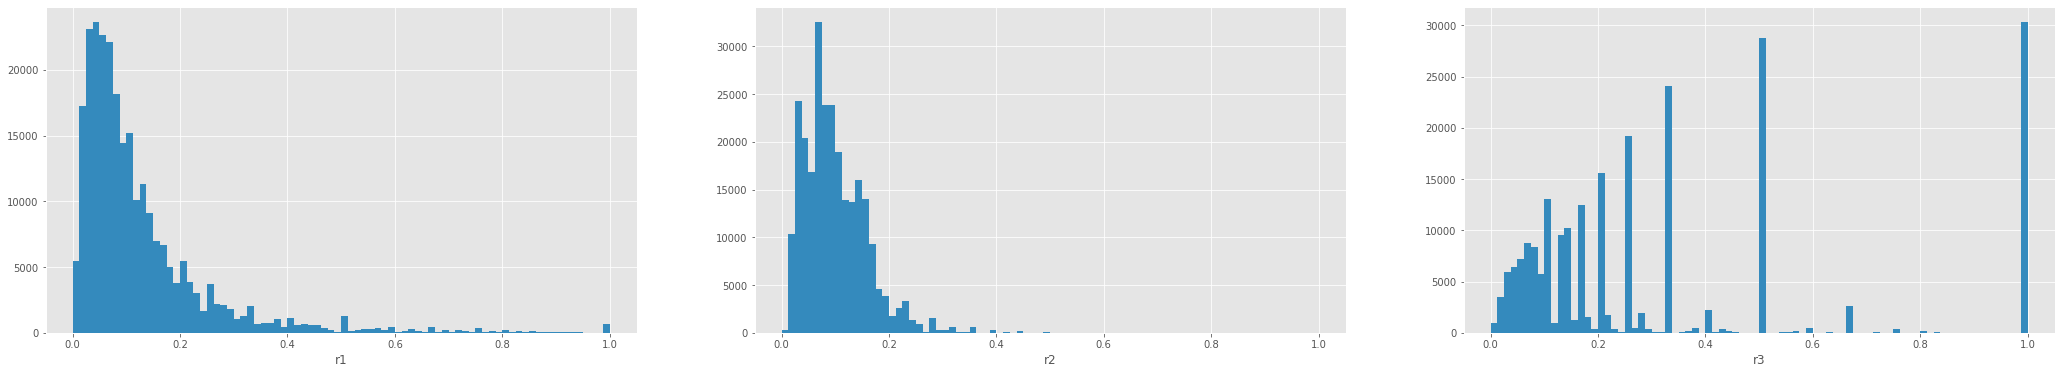

In [128]:
## 点击购买比分布
color = sns.color_palette()

fig = plt.figure(figsize=(36, 6))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.hist(train_data[colnm[i+34]],range=[0,1],bins = 80,color = color[1])
    plt.xlabel(colnm[i+34],fontsize = 12)

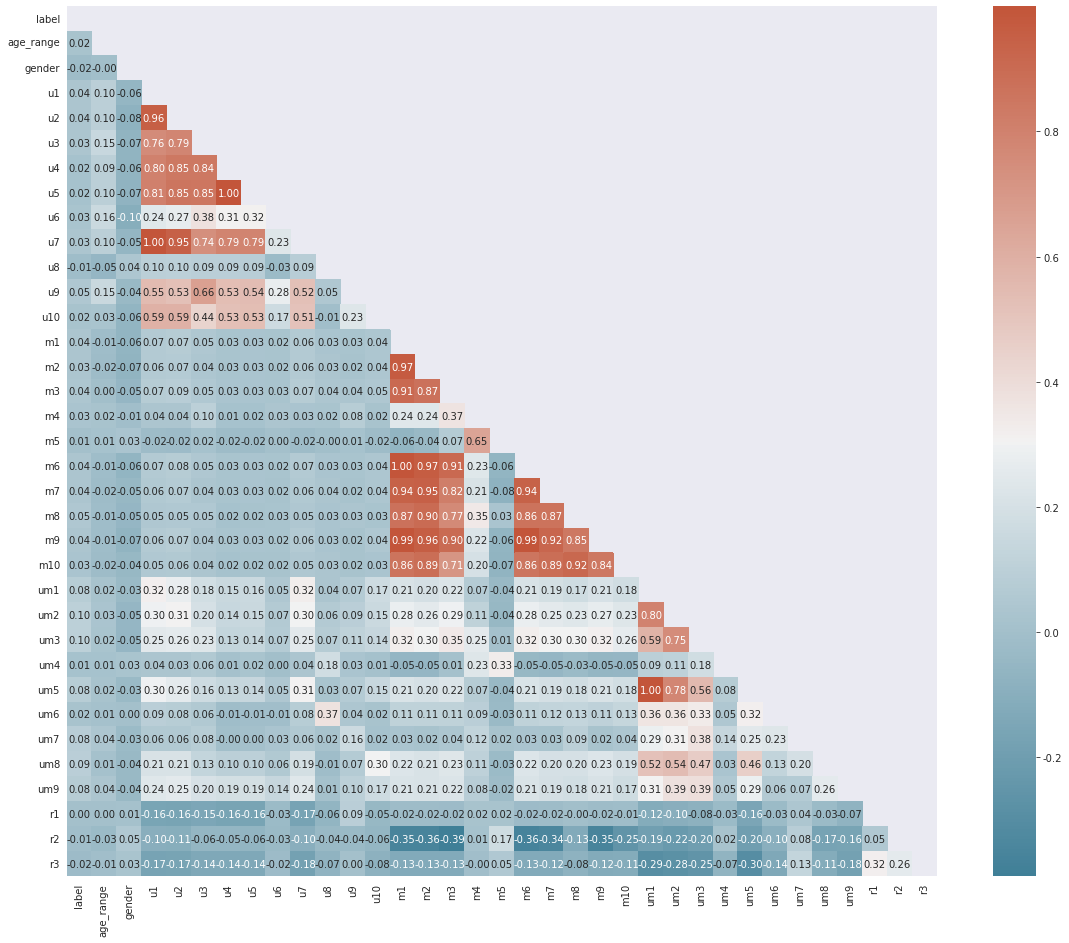

In [135]:
# 特征相关性
sns.set_style("dark")
plt.figure(figsize = (20,16))
colnm = train_data.columns.tolist()[2:38]
mcorr = train_data[colnm].corr()
# n生成一个和mcorr相同shape的全0数组
mask = np.zeros_like(mcorr, dtype=np.bool)
# 返回方阵的上三角矩阵的索引
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(225, 20, as_cmap=True)
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True,fmt='0.2f')

## 使用DIN模型进行用户复购预测

In [139]:
from sklearn.preprocessing import LabelEncoder
# 对离散特征做LabelEncoder（0～n-1）
lbe_merchant_id=LabelEncoder()
lbe_merchant_id.fit(np.r_[0,user_log['merchant_id'].values])
user_log['merchant_id']=lbe_merchant_id.transform(user_log['merchant_id'])
matrix['merchant_id']=lbe_merchant_id.transform(matrix['merchant_id'])

lbe_user_id=LabelEncoder()
user_log['user_id']=lbe_user_id.fit_transform(user_log['user_id'])
user_info['user_id']=lbe_user_id.transform(user_info['user_id'])
matrix['user_id']=lbe_user_id.transform(matrix['user_id'])

lbe_item_id=LabelEncoder()
user_log['item_id']=lbe_item_id.fit_transform(user_log['item_id'])
lbe_cat_id=LabelEncoder()
user_log['cat_id']=lbe_cat_id.fit_transform(user_log['cat_id'])
lbe_brand_id=LabelEncoder()
user_log['brand_id']=lbe_brand_id.fit_transform(user_log['brand_id'])

user_log['merchant_id'].max(),user_log['user_id'].max() #统计不同商家个数：4994+1，不同买家的个数：19111+1(小样本时)
print(user_log['merchant_id'].max())
print(user_log['user_id'].max())

4995
424169


In [ ]:
matrix.fillna(0, inplace=True)
# # 修改age_range字段名称为 age_0, age_1, age_2... age_8
temp = pd.get_dummies(matrix['age_range'], prefix='age')
matrix = pd.concat([matrix, temp], axis=1)
temp = pd.get_dummies(matrix['gender'], prefix='g')
matrix = pd.concat([matrix, temp], axis=1)
matrix.drop(['age_range', 'gender'], axis=1, inplace=True)

lbe_action_type={0:1,1:2,2:3,3:4}
user_log['action_type']=user_log['action_type'].map(lbe_action_type) #action_type映射成1,2,3,4；方便后面用0补缺固定长度

# 用户行为sequence
# 把user_log里同user的这些数据合并成一个list
temp=pd.DataFrame(user_log.groupby('user_id')['merchant_id','action_type'].agg(lambda x:list(x)))
# 列名称改成hist_merchant_id 和 hist_action_type 
temp.columns=['hist_merchant_id','hist_action_type']
matrix = matrix.merge(temp, on=['user_id'], how='left')

# 截取，补缺到定长M个
M=500
for feature in ['hist_merchant_id','hist_action_type']:
    matrix[feature]=matrix[feature].map(lambda x:np.array(x+[0]*(M-len(x)))[:M])
#print(matrix.info())

# 分割训练数据和测试数据
train_data = matrix[matrix['origin'] == 'train'].drop(['origin'], axis=1)
test_data = matrix[matrix['origin'] == 'test'].drop(['label', 'origin'], axis=1)
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']

#保存特征文件，调试不同算法模型
train_X.to_csv('./train_X.csv', index=False)
train_y.to_csv('./train_y.csv', index=False)
test_data.to_csv('./test_data.csv', index=False)
# print("ok")

In [ ]:
##### 使用DIN模型 ######
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from deepctr.inputs import SparseFeat,VarLenSparseFeat,DenseFeat,get_feature_names
from deepctr.models import DIN, DIEN, DSIN
from sklearn.metrics import classification_report

M=500
#读取submission,存储结果
import gc
import numpy as np
import pandas as pd
import re
submission = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1/test_format1.csv') # 加载全量样本时
# submission = pd.read_csv('./Repeat Buyers Prediction DataSet/data_format1_small/test.csv') # 加载小样本时
submission['origin'] = 'test'
print(submission.head())

#读取保存好的特征文件，注意这里重新读取会将'hist_merchant_id','hist_action_type'读取成str,而不是list，因此需要将train_X和test_data中的hist_merchant_id，hist_action_type转回list
train_X=pd.read_csv('./train_X.csv')
train_y=pd.read_csv('./train_y.csv')
test_data=pd.read_csv('./test_data.csv')
#将train_X和test_data中的hist_merchant_id，hist_action_type转回list
def strlist_to_list(s):
  s=re.sub('[\[\]]','',s)#删除中括号
  s=s.replace("\n", "")#删除换行符号
  s=s.split() # 以空格（一个或多个）分隔
  s=[float(num) for num in s]
  return s
train_X['hist_merchant_id']=train_X['hist_merchant_id'].map(strlist_to_list)
train_X['hist_action_type']=train_X['hist_action_type'].map(strlist_to_list)
test_data['hist_merchant_id']=test_data['hist_merchant_id'].map(strlist_to_list)
test_data['hist_action_type']=test_data['hist_action_type'].map(strlist_to_list)
#print(type(train_X['hist_merchant_id'].values))
#print("ok")

train_X['action_type']=3 #因为这里用户在商家是购买过商品的，所以添加了一列action_type，且设为3

#格式转换（将之前的特征名封装成了一个类）
feature_columns = []
for column in train_X.columns:
  if column != 'hist_merchant_id' and column != 'hist_action_type':
    #print(column)
    num = train_X[column].nunique()
    if num > 10000:
        dim = 10
    else:
        if num > 1000:
            dim = 8
        else:
            dim = 4
    #print(num)
    if column  == 'user_id':
        feature_columns += [SparseFeat(column, 424169+1, embedding_dim=dim)]
    elif column  == 'merchant_id':
        feature_columns += [SparseFeat(column, 4995+1, embedding_dim=dim)]
    elif column  == 'action_type':
        feature_columns += [SparseFeat(column, 4+1, embedding_dim=dim)]
    else:
        feature_columns += [DenseFeat(column, 1)]

#print(train_X['hist_merchant_id'].shape)
#M = len(train_X['hist_merchant_id'])
#print('M=', M)

# maxlen为历史信息的长度，vocabulary_size为onehot的长度；VarLenSparseFeat为序列类型特征
# 注意正确使用VarLenSparseFeat，不要加参数：weight_name='hist_merchant_id'，weight_name='hist_action_type'
feature_columns += [VarLenSparseFeat(SparseFeat('hist_merchant_id', vocabulary_size=424169+1, embedding_dim=8), maxlen=M),
                   VarLenSparseFeat(SparseFeat('hist_action_type', vocabulary_size=4+1, embedding_dim=4),maxlen=M)]
hist_features=['merchant_id','action_type']
print(feature_columns)

# 使用DIN模型
# 这里要求inputs shapes删除维度（/通道数）以后形状相同;通道数位置为-1，即倒数第一个数
model=DIN(feature_columns, hist_features)
# 使用Adam优化器，二分类的交叉熵
model.compile('adam', 'binary_crossentropy', metrics=['binary_crossentropy'])
# 组装train_model_input，得到feature names，将train_X转换为字典格式
feature_names=list(train_X.columns)
train_model_input ={name:train_X[name].values for name in feature_names}

# histroy输入必须是二维数组
#进度条
from tqdm import tqdm
for fea in ['hist_merchant_id','hist_action_type']:
    l = []
    for i in tqdm(train_model_input[fea]):
        l.append(i)
    train_model_input[fea]=np.array(l) #转换成二维数组

history = model.fit(train_model_input, train_y, verbose=True, epochs=10, validation_split=0.2,batch_size=512)

# 转换test__model_input
test_data['action_type']=3
test_model_input = {name:test_data[name].values for name in feature_names}#字典
from tqdm import tqdm
for fea in ['hist_merchant_id','hist_action_type']:
    l = []
    for i in tqdm(test_model_input[fea]):
        l.append(i)
    test_model_input[fea]=np.array(l)#二维数组

# 得到预测结果
prob = model.predict(test_model_input)
submission['prob'] = prob
#print(submission.head())
submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('./prediction.csv', index=False)